In [1]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce GTX 1650 (UUID: GPU-f010ab2c-9f8a-dfc2-d888-045d09377d67)


## Get a text dataset

In [2]:
import zipfile

def unzip_data(filename):
    zip_ref = zipfile.ZipFile(filename, "r")
    zip_ref.extractall()
    zip_ref.close()

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

unzip_data("nlp_getting_started.zip")

'wget' is not recognized as an internal or external command,
operable program or batch file.


## Visualizing a text dataset

In [4]:
import pandas as pd

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train_df["text"][:10]

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
5    #RockyFire Update => California Hwy. 20 closed...
6    #flood #disaster Heavy rain causes flash flood...
7    I'm on top of the hill and I can see a fire in...
8    There's an emergency evacuation happening now ...
9    I'm afraid that the tornado is coming to our a...
Name: text, dtype: object

In [6]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [7]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
train_df.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [9]:
len(train_df), len(test_df)

(7613, 3263)

In [10]:
import random

random_index = random.randint(0, len(train_df)-5)  # Create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
    _, text, target = row
    print(f"Target {target}", "(real disaster)" if target > 0 else "(not real diaster)")
    print(f"Text:\n{text}\n")
    print(f"---\n")

Target 0 (not real diaster)
Text:
Live updates: Boyd gets out of trouble in 5th http://t.co/3ugfpwMY2x via @detroitnews

---

Target 0 (not real diaster)
Text:
@SexyDragonMagic I've come to the realization that I just don't have the attention span for mass battle games. Both painting and playing.

---

Target 0 (not real diaster)
Text:
@heebsterrr_ I remember the heat wave the year I went bruh and they don't have AC ????

---

Target 0 (not real diaster)
Text:
He was only .4 of a second faster than me and I overtook him twice (then crashed) tru luv &lt;3 &lt;3

---

Target 1 (real disaster)
Text:
@Louis_Tomlinson incredible? THE CHILDREN WERE SCREAMING BUILDINGS WERE BURNING AND I WAS DANCING IN THE ASHES

---



### Split data into trianing and validation sets

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42)

In [13]:
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [14]:
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Text vectorization (tokenization)

In [15]:
import tensorflow as tf
print(tf.__version__)

2.16.1


In [22]:
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=None,
                                 standardize="lower_and_strip_punctuation",
                                 split="whitespace",
                                 ngrams=None,
                                 output_mode="int",  # how to map tokens to numebers
                                 output_sequence_length=None)

In [23]:
# Find average number of tokens
round(sum([len(i.split()) for i in train_sentences]) / len(train_sentences))

15

In [24]:
# Setup text vectorization with custom variables
max_vocab_length = 10000
max_length = 15

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_sequence_length=max_length)

In [25]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [26]:
sample_sentence = "There's a Wall Street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 264,    3, 1104,  698,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]], dtype=int64)>

In [29]:
# Chose a random sentence from training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
\n\nVectorized version:\n {text_vectorizer([random_sentence])}")

Original text:
Going to go drown my sorrows with sad music brb

Vectorized version:
 [[ 104    5  112  486   13 4569   14 1061  571    1    0    0    0    0
     0]]


In [31]:
# Get the unique words in the vocab
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


In [34]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             embeddings_initializer="uniform",
                             input_length=max_length,
                             name="embedding_1")
embedding

<Embedding name=embedding_1, built=False>

In [39]:
random_sentence = random.choice(train_sentences)
print(f"Original first word from sentence: {random_sentence}")
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original first word from sentence: Massive Typhoon heads toward Taiwan. http://t.co/Na2Ey64Vsg


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.00596235,  0.01100093,  0.04480072, ..., -0.03478084,
         -0.04622444,  0.01905574],
        [-0.0431531 , -0.04933596, -0.03472952, ..., -0.03401176,
          0.02375028, -0.0289243 ],
        [-0.00278095, -0.04442969,  0.00462788, ...,  0.01451072,
         -0.02730105,  0.01301977],
        ...,
        [-0.01846194,  0.02405633, -0.01175625, ..., -0.00942329,
         -0.01193336, -0.03225898],
        [-0.01846194,  0.02405633, -0.01175625, ..., -0.00942329,
         -0.01193336, -0.03225898],
        [-0.01846194,  0.02405633, -0.01175625, ..., -0.00942329,
         -0.01193336, -0.03225898]]], dtype=float32)>

In [40]:
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 0.00596235,  0.01100093,  0.04480072,  0.0104623 ,  0.0480376 ,
       -0.04995808, -0.03285468,  0.00195433,  0.00708574,  0.04151526,
       -0.04810894,  0.04436624,  0.02446939, -0.03976675, -0.02998507,
        0.00856195, -0.00912   , -0.00416783, -0.04190894, -0.02101814,
        0.01350078, -0.00315754, -0.04439889, -0.00911033,  0.01263783,
        0.03453947, -0.02849706, -0.00468504,  0.04160002, -0.03863811,
        0.01454932,  0.03305235,  0.03902531,  0.02610636, -0.02411813,
       -0.0495464 , -0.00985085,  0.00724477, -0.02841947, -0.00737273,
        0.04005944, -0.02422179,  0.01377877, -0.00698482, -0.00181097,
        0.04125199,  0.04744798, -0.02460721,  0.03617487,  0.01587169,
        0.0265717 ,  0.04366434, -0.01615443, -0.00879171, -0.02570703,
       -0.04210132, -0.00869393, -0.03043009,  0.01071992,  0.03151847,
        0.00012507,  0.01889148,  0.02692812,  0.01056138, -0.0267007 ,
       -0.023038

In [41]:
len(sample_embed[0][0])

128

### Following models:
* Model 0: Naive Bayes (baseline)
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model
* Model 3: GRU model
* Model 4: Bidirectional-LSTM model
* Model 5: 1D Convolutional Neural Network
* Model 6: TensorFlow Hub Pretrained Feature Extractor
* Model 7: Same as model 6 with 10% of training data

### Each experiment will go through the following steps:
* Construct the model
* Train the model
* Make predictions with the model
* Track prediction evaluation metrics for later comparison

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
    ("clf", MultinomialNB()), # model the text
])

model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [50]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [51]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
      dtype=int64)

In [53]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
    """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
    Args:
    y_true = true labels in the form of a 1D array
    y_pred = predicted labels in the form of a 1D array

    Return a dictionary of accuracy, precision, recall, f1-score.
    """
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {"accuracy": model_accuracy,
                    "precision": model_precision,
                    "recall": model_recall,
                    "f1": model_f1}
    return model_results

In [55]:
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [57]:
from helper_functions import create_tensorboard_callback

SAVE_DIR = "model_logs"

In [70]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [71]:
model_1.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [72]:
model_1.summary()

Model: "model_1_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_2            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,280,129 (4.88 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

In [73]:
model_1_history = model_1.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20240415-085311
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6619 - loss: 0.6097 - val_accuracy: 0.7822 - val_loss: 0.4977
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8837 - loss: 0.3710 - val_accuracy: 0.7874 - val_loss: 0.4612
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8996 - loss: 0.2883 - val_accuracy: 0.7887 - val_loss: 0.4648
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9138 - loss: 0.2429 - val_accuracy: 0.7782 - val_loss: 0.4793
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9252 - loss: 0.2102 - val_accuracy: 0.7822 - val_loss: 0.4985


In [74]:
model_1.evaluate(val_sentences, val_labels)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7713 - loss: 0.5331 


[0.49853748083114624, 0.7821522355079651]

In [75]:
embedding.weights

[<KerasVariable shape=(10000, 128), dtype=float32, path=embedding_1/embeddings>]

In [77]:
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


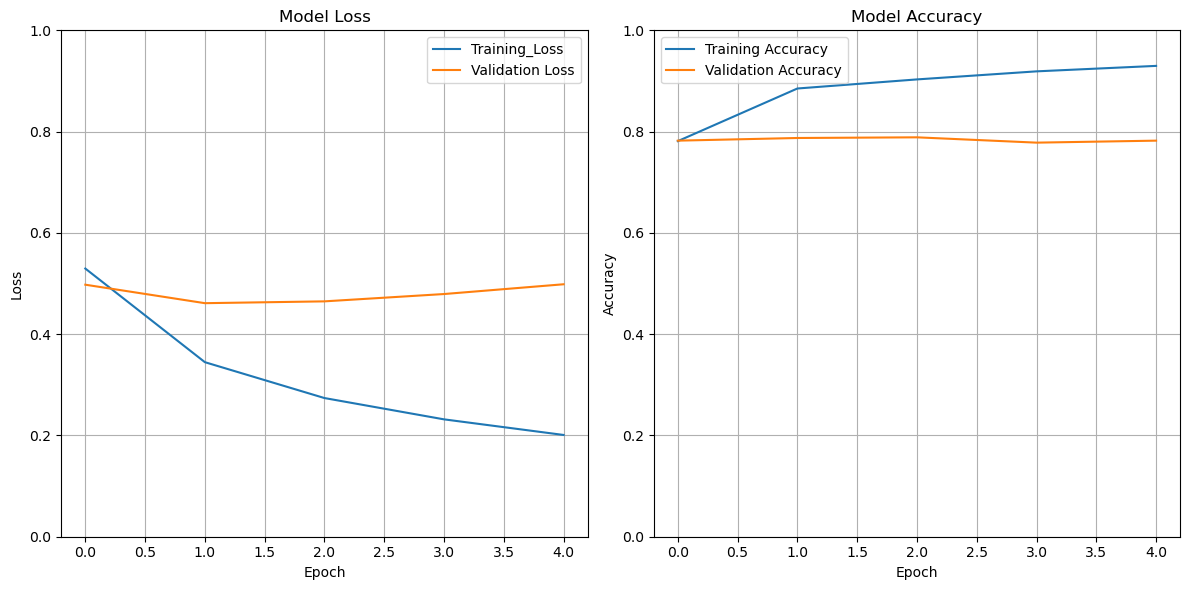

In [93]:
import matplotlib.pyplot as plt

def plot_training_history(model_history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    ax1.plot(model_history.history['loss'], label="Training_Loss")
    ax1.plot(model_history.history['val_loss'], label="Validation Loss")
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid()
    ax1.legend()
    ax1.set_ylim(0, 1)
    
    ax2.plot(model_history.history['accuracy'], label="Training Accuracy")
    ax2.plot(model_history.history['val_accuracy'], label="Validation Accuracy")
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.grid()
    ax2.legend()
    ax2.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

plot_training_history(model_history=model_1_history)

In [94]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


array([[0.3413137 ],
       [0.7549888 ],
       [0.99822754],
       [0.15775055],
       [0.07329997],
       [0.95183265],
       [0.88782346],
       [0.996542  ],
       [0.97683614],
       [0.39312994]], dtype=float32)

In [96]:
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [98]:
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.21522309711287,
 'precision': 0.7849731976577976,
 'recall': 0.7821522309711286,
 'f1': 0.7797935460636591}

In [99]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

In [102]:
def compare_baseline_to_new_results(baseline_results, new_model_results):
    for key, value in baseline_results.items():
        print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results=baseline_results,
                                new_model_results=model_1_results)

Baseline accuracy: 79.27, New accuracy: 78.22, Difference: -1.05
Baseline precision: 0.81, New precision: 0.78, Difference: -0.03
Baseline recall: 0.79, New recall: 0.78, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.01


In [103]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [104]:
model_1.summary()

Model: "model_1_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_2            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,840,389 (14.65 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,560,260 (9.77 MB)

In [106]:
# Get the weight matrix of mebedding layer
# (these are the numerical patterns between the text in the training dataset the model has learned)
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)
